## Code to compare the performance of QuakeFlow to conventional catalogs

In [3]:
from collections import defaultdict
import numpy as np
import pandas as pd
import time
import requests
import json
import obspy
from obspy.clients.fdsn import Client
import geopandas as gpd

In [4]:
import warnings
warnings.filterwarnings('ignore')

#### Load in results from QuakeFlow from a response json file:

In [5]:
load_file = 'result_example'

In [10]:
f = open(load_file+'.json')
result = json.load(f)

catalog_gamma = result["catalog"]
picks_gamma = result["picks"]
print("Catalog:")
display(pd.DataFrame(catalog_gamma)[["time", "latitude", "longitude", "depth(m)", "magnitude", "covariance"]])
print("Association:")
df = pd.DataFrame(picks_gamma)
df.head()

Catalog:


,time,latitude,longitude,depth(m),magnitude,covariance
0,2018-10-01T09:42:15.237,58.17243,-155.232183,13715.249876,1.941594,"2.224,0.391,0.278"


Association:


,id,timestamp,prob,amp,type,event_idx,prob_gmma
0,AV.ACH..BH,2018-10-01T09:42:19.528,0.976541,0.000076,p,0,0.081009
1,AV.ACH..BH,2018-10-01T09:42:20.918,0.930866,0.000076,s,0,0.100742
2,AV.ANCK..BH,2018-10-01T09:42:21.368,0.914994,0.000003,p,0,0.059387
3,AV.ANCK..BH,2018-10-01T09:42:23.798,0.851268,0.000003,s,0,0.069766
4,AV.KABU..BH,2018-10-01T09:42:19.308,0.981695,0.000031,p,0,0.101909


#### Load in the original catalog information:

In [11]:
cat = obspy.core.event.read_events('XO_2018_10.quakeml')
event = cat.events[2]
print('Earthquake on',str(event.origins[0].time))
print('Earthquake has',str(len(event.picks)),'picks')
print('Earthquake magnitude is',str(event.magnitudes[0].mag))

### Let's start with a look at how the picks compare between PhaseNet and the original catalog.

In [31]:
# Starting off by getting a useful dataframe from the quakeml file of all the pertinent pick info.
# This is the ground truth.

# Match phase to picks:
phase = [];arr_id = [];
for arrivals in event.origins[0].arrivals:
    phase.append(arrivals.phase.lower())
    txt=int(''.join(filter(str.isdigit, str(arrivals.resource_id))))
    arr_id.append(txt)
arr_df = pd.DataFrame({'og_phase':phase,'arr_id':arr_id})
arr_df.head()
pick_id = [];timestamp = [];sta_code=[];
for pick in event.picks:
    sta_code.append(pick.waveform_id.network_code+'.'+pick.waveform_id.station_code+'..'+pick.waveform_id.channel_code[0:2])
    txt=int(''.join(filter(str.isdigit, str(pick.resource_id))))
    pick_id.append(txt)
    timestamp.append(pick.time)
pick_df = pd.DataFrame({'sta_code':sta_code,'pick_id':pick_id,'og_timestamp':timestamp})
pick_df.head()

# Merge the arrivals and the picks:
ground_truth = pd.merge(left=arr_df, right=pick_df, left_on='arr_id', right_on='pick_id')

ground_truth.head()

,og_phase,arr_id,sta_code,pick_id,og_timestamp
0,p,282,AV.KCE..EH,282,2018-10-01T09:42:18.551000Z
1,p,288,XO.ET20..HH,288,2018-10-01T09:42:20.965000Z
2,s,289,AV.KCG..EH,289,2018-10-01T09:42:20.979000Z
3,p,290,AV.KVT..EH,290,2018-10-01T09:42:21.104000Z
4,p,291,AV.ANCK..BH,291,2018-10-01T09:42:21.368000Z


#### Now, see which picks were common between the original catalog and PhaseNet by joining based on phase type and station code. This allows us to see how accurate the picks it got were. 

In [16]:
comp = pd.merge(left = df, right = ground_truth, left_on=['id','type'],right_on=['sta_code','og_phase'])
comp.head()

,id,timestamp,prob,amp,type,event_idx,prob_gmma,og_phase,arr_id,sta_code,pick_id,og_timestamp
0,AV.ACH..BH,2018-10-01T09:42:19.528,0.976541,0.000076,p,0,0.081009,p,284,AV.ACH..BH,284,2018-10-01T09:42:19.503000Z
1,AV.ACH..BH,2018-10-01T09:42:20.918,0.930866,0.000076,s,0,0.100742,s,287,AV.ACH..BH,287,2018-10-01T09:42:20.854000Z
2,AV.ANCK..BH,2018-10-01T09:42:21.368,0.914994,0.000003,p,0,0.059387,p,291,AV.ANCK..BH,291,2018-10-01T09:42:21.368000Z
3,AV.ANCK..BH,2018-10-01T09:42:23.798,0.851268,0.000003,s,0,0.069766,s,293,AV.ANCK..BH,293,2018-10-01T09:42:23.548000Z
4,AV.KABU..BH,2018-10-01T09:42:19.308,0.981695,0.000031,p,0,0.101909,p,283,AV.KABU..BH,283,2018-10-01T09:42:19.328000Z


### Make plots to visualize the accuracy of the correct PhaseNet picks, and also quantify/plot up false positives, negatives, etc.

#### First calculate time residuals between picks, as original-QuakeFlow:

<AxesSubplot:>

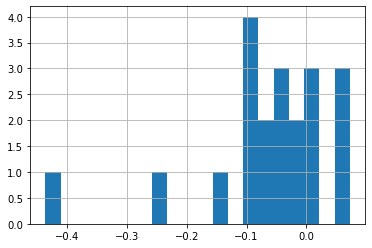

In [55]:
# Convert QuakeFlow timestamp results to datetime:
comp['timestamp'] = [obspy.UTCDateTime(t) for t in comp['timestamp']]
# Add residual column:
comp['pick_resid'] = comp['og_timestamp'] - comp['timestamp']

comp.head()
comp['pick_resid'].hist(bins=20)

### Let's start off by calling correct picks those with a residual < 0.5 seconds.

In [59]:
resid_max = 0.5

true_positives = len(np.abs(comp['pick_resid'])<resid_max)

20


#### Now let's take a closer look at the "new" picks that PhaseNet got, and see if they look real:

## TO-DO: Download the waveform from the "new" pick, plot the PhaseNet pick atop to evaluate it

In [78]:
cross = pd.merge(left = df, right = ground_truth,how="outer", left_on=['id','type'],right_on=['sta_code','og_phase'])

# Picks that PhaseNet got but aren't in the conventional catalog:
new_picks = cross[cross['og_timestamp'].isna()]
new_picks

client = Client("iris")
interval = 30 #s
starttime = event.origins[0].time
endtime = starttime + interval
stream = obspy.Stream()
for i in range(len(new_picks)):
    txt=new_picks.iloc[i]['id']
    txt.split('.')
    # tmp = client.get_waveforms(network.code, station.code, "*", channel, starttime, endtime)
    # stream += tmp



AV.KEL..EH
AV.KVT..EH
TA.P17K..BH
TA.Q16K..BH
TA.Q18K..BH
TA.Q18K..BH
TA.R18K..BH
XO.ET20..HH
